In [33]:
import matplotlib.pylab as plt
from matplotlib.lines import Line2D
import numpy as np

from sklearn.datasets import load_digits
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from squlearn import Executor
from squlearn.encoding_circuit import ChebyshevPQC
from squlearn.kernel.qsvc import QSVC
from squlearn.kernel.lowlevel_kernel import ProjectedQuantumKernel

In [34]:
import pennylane as qml
from squlearn import Executor

executor = Executor(qml.device("lightning.gpu", wires=4))

In [35]:
# executor = Executor()

In [36]:
X, y = load_digits(return_X_y=True)
# plot_dataset(X, y, rows=5)


In [37]:
X_tsne = TSNE(n_components=2, learning_rate="auto", init="random", perplexity=40).fit_transform(X)


In [38]:
rows = np.random.choice(np.arange(1000, X.shape[0]), 5, replace=False)
# plot_numbers(X[rows, :], y[rows], title="label:")

# plot_data_in_feature_space(X_tsne, y, highlight_rows=rows)

In [47]:
n_samples = 1000

X_train, X_test, y_train, y_test = train_test_split(
    X_tsne[:n_samples, :],
    y[:n_samples],
    test_size=0.33,
    random_state=42,
)

In [49]:
print(y_train)

[2 0 8 2 0 3 3 9 8 6 3 8 1 9 8 6 0 8 1 6 2 8 9 9 5 1 7 8 1 4 9 4 5 4 6 8 8
 3 2 8 9 3 0 7 6 1 9 9 5 9 4 5 6 6 9 8 8 2 3 9 0 4 2 7 0 1 9 1 4 8 4 7 3 5
 5 0 1 6 2 4 0 5 5 8 4 4 0 1 2 7 8 9 4 7 1 4 3 7 8 6 9 6 3 1 2 2 7 7 9 1 6
 1 4 7 9 6 5 5 9 7 9 4 7 5 8 7 5 3 9 6 5 2 6 3 4 6 8 9 9 5 3 9 5 3 1 4 6 8
 3 2 6 7 1 0 7 7 1 9 9 4 4 7 4 4 8 0 6 0 7 6 6 1 9 6 7 6 8 8 2 9 1 2 0 5 4
 7 7 0 7 2 4 0 1 2 3 5 2 9 8 1 1 4 6 8 4 0 3 2 2 3 6 5 7 0 5 8 0 0 2 0 2 4
 1 2 4 7 2 2 5 1 6 3 6 1 7 2 9 0 1 4 9 4 0 2 4 2 2 2 3 5 4 9 5 4 5 1 1 6 8
 3 5 7 1 7 6 4 9 7 8 4 7 8 6 8 1 3 3 2 4 1 2 3 2 6 2 9 2 1 6 3 4 7 2 4 6 9
 0 9 5 8 1 7 7 0 0 4 6 7 2 5 7 0 9 3 7 3 6 5 6 6 4 0 6 5 6 2 3 6 5 3 2 5 9
 5 4 3 1 3 5 5 6 1 4 6 9 8 1 7 8 2 2 6 2 8 9 0 6 5 8 1 4 0 1 7 2 6 7 4 8 0
 2 4 2 6 4 5 7 6 5 6 1 3 9 2 9 1 8 2 9 3 1 6 1 3 9 4 8 8 0 7 5 9 7 9 1 3 4
 8 4 6 8 4 3 8 3 9 0 6 0 4 7 3 8 0 1 8 1 7 0 4 7 3 6 1 3 5 5 0 6 9 9 0 7 2
 4 8 3 5 2 3 4 2 6 5 9 8 2 8 7 3 9 8 1 3 8 3 0 7 8 1 8 0 7 9 1 8 7 9 8 5 4
 8 8 8 7 5 9 4 6 1 7 8 6 

In [40]:
scaler = MinMaxScaler((-0.9, 0.9))

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

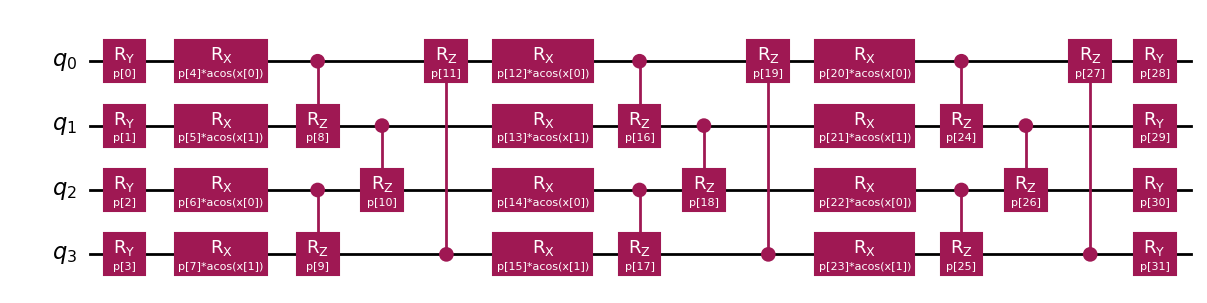

In [41]:
encoding_circuit = ChebyshevPQC(num_qubits=4, num_features=2, num_layers=3)
encoding_circuit.draw(output="mpl")

In [42]:
kernel = ProjectedQuantumKernel(
    encoding_circuit=encoding_circuit,
    executor=executor,
    measurement="XYZ",
    outer_kernel="gaussian",
    initial_parameters=np.random.rand(encoding_circuit.num_parameters),
    gamma=0.5,
)

In [50]:
print(X_train)

[[-29.72829   10.997842]
 [  9.19114  -47.04158 ]
 [-10.645244  -5.213791]
 ...
 [-31.3162     9.564082]
 [ 13.712525 -47.681168]
 [ 11.50015  -11.912443]]


In [43]:
qsvc = QSVC(quantum_kernel=kernel)
qsvc.fit(X_train, y_train)

QSVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
     decision_function_shape='ovr', max_iter=-1, probability=False,
     quantum_kernel=<squlearn.kernel.lowlevel_kernel.projected_quantum_kernel.ProjectedQuantumKernel object at 0x7164d86ef970>,
     random_state=None, shrinking=True, tol=0.001, verbose=False)

In [44]:
predictions = qsvc.predict(X_train)
print(f"Train accuracy score {accuracy_score(y_train, predictions)}")
predictions = qsvc.predict(X_test)
print(f"Test accuracy score {accuracy_score(y_test, predictions)}")

Train accuracy score 0.9462686567164179
Test accuracy score 0.9575757575757575


In [45]:
# plot_results(
#     clf=qsvc,
#     X_train=X_train,
#     y_train=y_train,
#     X_test=X_test,
#     y_test=y_test,
#     X_highlight=scaler.transform(X_tsne[rows]),
#     y_highlight=y[rows],
#     X_range=[(-0.9, 0.9), (-0.9, 0.9)],
#     resolution=30,
# )

In [46]:
y_pred = qsvc.predict(scaler.transform(X_tsne[rows, :]))

# plot_numbers(X[rows, :], y_pred, title="prediction:")